In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
#Input start time and duration. Return Duration in minutes
def to_duration(s, f):
    s = to_hrs(s)
    f = to_hrs(f)
    m = (f-s)*60
    m = float('%.2f'%m)
    return m

#Input start time (hh:mm:ss). Return Start time (hours) float value.
def to_hrs(ts):
    h, m, s = map(int,ts.split(':'))
    hrs = h + m/60
    hrs = float('%.2f'%hrs)
    return hrs

activities = {
        'Eat':['Eat','Eat_Breakfast','Eat_Dinner','Eat_Lunch'], 
        'Sleep':['Sleep'],
        'Medicine':['Morning_Meds', 'Evening_Meds']
}

In [58]:
#Implementation of Trapezoidal Membership Function for fuzzy Modelling

#For Normal Behavior
def tmf(x,a,b,c,d):
    c1 = (x-a)/(b-a)
    c2 = (d-x)/(d-c)
    y = max(min(c1, c2, 1), 0)
    return y

#For abnormality where Start Time/ Duration is less than Normal timing
def tmf_abnormal_left(x, a, b):
    if x < a:
        return 1
    elif x >= a and x <= b:
        return (b-x)/(b-a)
    elif x > b:
        return 0

#For abnormality where Start Time/ Duration is more than Normal timing
def tmf_abnormal_right(x, c, d):
    if x < c:
        return 0
    elif x >= c and x <= d:
        return (c-x)/(c-d)
    elif x > d:
        return 1

#Change Percentage factor according to your convinient
percentage_factor = 0.3

#This will plot Fuzzy function for each activity
def plot_fuzzy(start_time_minimum, start_time_maximum, duration_minimum, duration_maximum,  title):
    
    c = start_time_maximum
    b = start_time_minimum
    diff = c-b
    a = start_time_minimum - (diff*percentage_factor)
    d = start_time_maximum + (diff*percentage_factor)
    
    fig, (start, duration) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    fig.set_figheight(4)
    fig.suptitle(title,fontsize=20)
    
    X = np.arange(a-diff, d+ diff, 0.01)
    normal = [tmf(x,a,b,c,d) for x in X]
    ab_left = [tmf_abnormal_left(x, a, b) for x in X]
    ab_right = [tmf_abnormal_right(x, c, d) for x in X]
    
    #start.figure()
    start.plot(X, normal)
    start.plot(X, ab_left)
    start.plot(X, ab_right)
    start.set_title('Start Time')
    start.set_ylim([0,1.1])
    
    
    #DURATION
    db = duration_minimum
    dc = duration_maximum
    diff = dc-db
    da = db - (diff*percentage_factor)
    dd = dc + (diff*percentage_factor)
    
    X = np.arange(da-diff, dd+ 2*diff, 0.01)
    normal = [tmf(x,da,db,dc,dd) for x in X]
    ab_left = [tmf_abnormal_left(x, da, db) for x in X]
    ab_right = [tmf_abnormal_right(x, dc, dd) for x in X]
    
    #duration.figure()
    duration.plot(X, normal)
    duration.plot(X, ab_left)
    duration.plot(X, ab_right)
    duration.set_title('Duration')
    duration.set_ylim([0,1.1])
    
def get_abcd(b, c):
    diff = c - b
    a = b - (diff * percentage_factor)
    d = c + (diff * percentage_factor)
    return (a,b,c,d)

In [59]:
#Sequence related Functions
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

short = {
    'Sleep': 'S',
    'Morning_Meds': 'M',
    'Evening_Meds':'M',
    'Bathe': 'B',
    'Cook': 'C',
    'Cook_Breakfast': 'C',
    'Cook_Dinner': 'C',
    'Cook_Lunch': 'C',
    'Eat': 'E',
    'Eat_Breakfast':'E',
    'Eat_Dinner':'E',
    'Eat_Lunch':'E',
    'Wash_Breakfast_Dishes': 'W',
    'Wash_Dinner_Dishes': 'W',
    'Wash_Dishes': 'W',
    'Wash_Lunch_Dishes':'W'
}

def get_day_sequence(dataset, day):
    readpath = r'..\CASAS_DATA\HH' +dataset+ r'\processed_data\Day' + str(day) + '.csv'
    df = pd.read_csv(readpath)
    Act = list(df['Activity'])

    sequence = ['@']
    for act in Act:
        if act in short:
            if sequence[-1] != short[act]:
                sequence.append(short[act])
    seq = ''.join(sequence)
    return seq

def get_sequences(dataset):
    dirc =  r'..\CASAS_DATA\HH' +dataset+ r'\processed_data'
    Days = len(os.listdir(dirc))
    SEQ = []
    for day in range(1, Days+1):
        seq = get_day_sequence(dataset, day)
        SEQ.append(seq[1:])
    return SEQ

def compare_sequence(normals, sequence):
    best_day, best_score =0, 0
    best_alignment = None
    
    day = 1
    while day < len(normals):
        X = normals[day]
        Y = sequence
        

        alignments = pairwise2.align.localxx(X, Y)


        for a in alignments:
            if a.score >= best_score:
                best_percentage = (a.score/len(X))*100
                best_day = day
                best_alignment = a
        day += 1
    
    print(format_alignment(*best_alignment))
    print('Sequence matched by %.2f'%best_percentage + '%')
    

In [60]:
def get_day(dataset, day):
    read_path = r'..\CASAS_DATA\HH' +dataset+  r'\processed_data\Day' + str(day) + r'.csv'
    #print(read_path)
    day_df = pd.read_csv(read_path)
    
    med_day = day_df.loc[day_df['Activity'].isin(activities['Medicine'])]
    eat_day = day_df.loc[day_df['Activity'].isin(activities['Eat'])]
    sleep_day = day_df.loc[day_df['Activity'].isin(activities['Sleep'])]
    
    full = pd.concat([sleep_day, eat_day, med_day])
    return full
    
def get_day_report(normal, dataset, day):
    sleep_normal = normal[normal['Activity'] == 'Sleep']
    eat_normal = normal[normal['Activity'] == 'Eat']
    med_normal = normal[normal['Activity'] == 'Medicine']
    
    read_path = r'..\CASAS_DATA\HH' +dataset+  r'\processed_data\Day' + str(day) + r'.csv'
    print(read_path)
    day_df = pd.read_csv(read_path)
    
    med_day = day_df.loc[day_df['Activity'].isin(activities['Medicine'])]
    eat_day = day_df.loc[day_df['Activity'].isin(activities['Eat'])]
    sleep_day = day_df.loc[day_df['Activity'].isin(activities['Sleep'])]
    
    Normals = [sleep_normal, eat_normal, med_normal]
    Days = [sleep_day, eat_day, med_day]
    Total_activities = len(Normals)
    
    for df in Normals:
        for i in range(len(df)):
            row = df.iloc[i]
            #plot_fuzzy(row['Min_Start'], row['Max_Start'], row['Min_Dur'], row['Min_Dur'], row['Cluster'])
    
    Report = []
    for act in range(Total_activities):
        normal_df = Normals[act]
        Day_df = Days[act]
        
        for i in range(len(Day_df)):
            smax_normal = 0
            smin_al, smin_ar = 1,1 
            dmax_normal = 0
            dmin_al, dmin_ar = 1,0 
            day_row = Day_df.iloc[i]
            clus = ''
            loc = ''
            
            for j in range(len(normal_df)):
                normal_row = normal_df.iloc[j]
                
                sx = to_hrs(day_row['Start'])
                dx = to_duration(day_row['Finish'], day_row['Start'])
                
                mins, maxs, mind, maxd =  normal_row['Min_Start'], normal_row['Max_Start'], normal_row['Min_Dur'], normal_row['Max_Dur']
                
                sa,sb,sc,sd = get_abcd(mins, maxs)
                da,db,dc,dd = get_abcd(mind, maxd)
                
                if tmf(sx, sa,sb,sc,sd) > smax_normal:
                    clus = normal_row['Cluster']
                    smax_normal = max(smax_normal, tmf(sx, sa,sb,sc,sd))
                    smin_al = min(smin_al, tmf_abnormal_left(sx, sa, sb))
                    smin_ar = min(smin_ar, tmf_abnormal_right(sx, sc, sd))

                    dmax_normal = max(dmax_normal, tmf(dx, da,db,dc,dd))
                    dmin_al = min(dmin_al, tmf_abnormal_left(dx, da/2, db*2))
                    dmin_ar = min(dmin_ar, tmf_abnormal_right(dx, dc, dd*2))
                
                acti = normal_row['Activity']
                locs = normal_row['Location'].split('-')
                if day_row['Location'] in locs:
                    loc = 'Normal'
                else:
                    loc = 'Anomaly'
                
            Report.append([acti, clus , loc, smax_normal, smin_al, smin_ar, dmax_normal, dmin_al, dmin_ar])
    
    D = pd.DataFrame(Report, columns=['Activity', 'Cluster', 'Location','Start_Normal', 'Start_AbNormal_Left','Start_AbNormal_right','Duration_Normal','Duration_AbNormal_left','Duration_AbNormal_right' ])
    return D          
                
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))                
        

In [61]:
normal1 = pd.read_csv(r'..\CASAS_DATA\K-FOLD\HH101-HH103-HH109.csv')
normal2 = pd.read_csv(r'..\CASAS_DATA\K-FOLD\HH128-HH122-HH103.csv')
normal3 = pd.read_csv(r'..\CASAS_DATA\K-FOLD\HH109-HH128.csv')

SEQUENCES = []

for dataset in ['109', '128']:
    readpath = r'..\CASAS_DATA\HH' + dataset +'\Activities\Sequence.csv'
    seq_df = pd.read_csv(readpath)
    SEQUENCES.extend(list(seq_df['Sequence']))


In [62]:

normal3

,Activity,Cluster,Location,Start,Duration,Min_Start,Max_Start,Min_Dur,Max_Dur
0,Sleep,Sleep1,Bedroom,1.48,392.94,1.00,3.70,151.0,593.2
1,Sleep,Sleep2,Bedroom,23.13,89.49,14.48,24.98,1.0,215.2
2,Medicine,Medicine1,Kitchen-DiningRoom-Bathroom,8.13,3.00,6.13,11.32,3.0,3.0
3,Medicine,Medicine2,Kitchen-DiningRoom-Bathroom,21.38,3.00,18.45,23.60,3.0,3.0
4,Eat,Eat1,DiningRoom,13.44,10.42,6.98,23.48,1.0,31.0


In [63]:
dataset = '111'
day = 4
Anomaly_data = get_day_report(normal3, dataset, day)
day_df = get_day(dataset, day)
display_side_by_side([normal3, Anomaly_data, day_df], ['Normal Behavior','Anomaly Data', 'Real Data'])
print('\nSequnce Anomaly\n')
seq = get_day_sequence(dataset, day)
compare_sequence(SEQUENCES,seq )

..\CASAS_DATA\HH111\processed_data\Day4.csv


<ipython-input-58-a4d77e76d5b9>:5: RuntimeWarning: divide by zero encountered in double_scalars
  c1 = (x-a)/(b-a)
<ipython-input-58-a4d77e76d5b9>:6: RuntimeWarning: divide by zero encountered in double_scalars
  c2 = (d-x)/(d-c)


,Activity,Cluster,Location,Start,Duration,Min_Start,Max_Start,Min_Dur,Max_Dur
0,Sleep,Sleep1,Bedroom,1.480000,392.940000,1.000000,3.700000,151.000000,593.200000
1,Sleep,Sleep2,Bedroom,23.130000,89.490000,14.480000,24.980000,1.000000,215.200000
2,Medicine,Medicine1,Kitchen-DiningRoom-Bathroom,8.130000,3.000000,6.130000,11.320000,3.000000,3.000000
3,Medicine,Medicine2,Kitchen-DiningRoom-Bathroom,21.380000,3.000000,18.450000,23.600000,3.000000,3.000000
4,Eat,Eat1,DiningRoom,13.440000,10.420000,6.980000,23.480000,1.000000,31.000000
,Activity,Cluster,Location,Start_Normal,Start_AbNormal_Left,Start_AbNormal_right,Duration_Normal,Duration_AbNormal_left,Duration_AbNormal_right
0,Sleep,,Normal,0,1,1,0.000000,1.000000,0
1,Sleep,Sleep2,Normal,1,0,0,0.554933,0.880167,0
2,Eat,Eat1,Anomaly,1,0,0,0.000000,1.000000,0
3,Eat,Eat1,Anomaly,1,0,0,0.022222,1.000000,0



Sequnce Anomaly

1 SMWCEWCEWMWS
  || ||||||| |
2 SM-CEWCEWM-S
  Score=10

Sequence matched by 83.33%


In [64]:

dataset = '111'
day = 38
Anomaly_data = get_day_report(normal3, dataset, day)
day_df = get_day(dataset, day)
display_side_by_side([normal3, Anomaly_data, day_df], ['Normal Behavior','Anomaly Data', 'Real Data'])
print('\nSequnce Anomaly\n')
seq = get_day_sequence(dataset, day)
compare_sequence(SEQUENCES,seq )

..\CASAS_DATA\HH111\processed_data\Day38.csv


<ipython-input-58-a4d77e76d5b9>:5: RuntimeWarning: divide by zero encountered in double_scalars
  c1 = (x-a)/(b-a)
<ipython-input-58-a4d77e76d5b9>:6: RuntimeWarning: divide by zero encountered in double_scalars
  c2 = (d-x)/(d-c)


,Activity,Cluster,Location,Start,Duration,Min_Start,Max_Start,Min_Dur,Max_Dur
0,Sleep,Sleep1,Bedroom,1.480000,392.940000,1.000000,3.700000,151.000000,593.200000
1,Sleep,Sleep2,Bedroom,23.130000,89.490000,14.480000,24.980000,1.000000,215.200000
2,Medicine,Medicine1,Kitchen-DiningRoom-Bathroom,8.130000,3.000000,6.130000,11.320000,3.000000,3.000000
3,Medicine,Medicine2,Kitchen-DiningRoom-Bathroom,21.380000,3.000000,18.450000,23.600000,3.000000,3.000000
4,Eat,Eat1,DiningRoom,13.440000,10.420000,6.980000,23.480000,1.000000,31.000000
,Activity,Cluster,Location,Start_Normal,Start_AbNormal_Left,Start_AbNormal_right,Duration_Normal,Duration_AbNormal_left,Duration_AbNormal_right
0,Sleep,,Anomaly,0,1,1,0.000000,1.000000,0
1,Eat,Eat1,Anomaly,1,0,0,0.000000,1.000000,0
2,Eat,Eat1,Anomaly,1,0,0,0.000000,1.000000,0
3,Eat,Eat1,Anomaly,1,0,0,0.888889,0.333333,0



Sequnce Anomaly

1 S---MWCEWCEWM
  |   | |||||||
2 SCEWM-CEWCEWM
  Score=9

Sequence matched by 75.00%


In [65]:

dataset = '122'
day = 1

Anomaly_data = get_day_report(normal3, dataset, day)
day_df = get_day(dataset, day)
display_side_by_side([normal3, Anomaly_data, day_df], ['Normal Behavior','Anomaly Data', 'Real Data'])

print('\nSequnce Anomaly\n')
seq = get_day_sequence(dataset, day)
compare_sequence(SEQUENCES,seq )

..\CASAS_DATA\HH122\processed_data\Day1.csv


<ipython-input-58-a4d77e76d5b9>:5: RuntimeWarning: divide by zero encountered in double_scalars
  c1 = (x-a)/(b-a)
<ipython-input-58-a4d77e76d5b9>:6: RuntimeWarning: divide by zero encountered in double_scalars
  c2 = (d-x)/(d-c)


,Activity,Cluster,Location,Start,Duration,Min_Start,Max_Start,Min_Dur,Max_Dur
0,Sleep,Sleep1,Bedroom,1.480000,392.940000,1.000000,3.700000,151.000000,593.200000
1,Sleep,Sleep2,Bedroom,23.130000,89.490000,14.480000,24.980000,1.000000,215.200000
2,Medicine,Medicine1,Kitchen-DiningRoom-Bathroom,8.130000,3.000000,6.130000,11.320000,3.000000,3.000000
3,Medicine,Medicine2,Kitchen-DiningRoom-Bathroom,21.380000,3.000000,18.450000,23.600000,3.000000,3.000000
4,Eat,Eat1,DiningRoom,13.440000,10.420000,6.980000,23.480000,1.000000,31.000000
,Activity,Cluster,Location,Start_Normal,Start_AbNormal_Left,Start_AbNormal_right,Duration_Normal,Duration_AbNormal_left,Duration_AbNormal_right
0,Sleep,,Normal,0.000000,1.000000,1,0.000000,1,0
1,Sleep,Sleep2,Normal,0.015873,0.984127,0,0.000000,1,0
2,Sleep,Sleep2,Normal,1.000000,0.000000,0,0.134765,1,0
3,Eat,Eat1,Anomaly,1.000000,0.000000,0,0.022222,1,0



Sequnce Anomaly

1 SMWCEW-CEWMWS
  |  ||| |||| |
2 S--CEWSCEWM-S
  Score=9

Sequence matched by 75.00%


In [56]:

dataset = '113'
day = 39


Anomaly_data = get_day_report(normal3, dataset, day)
day_df = get_day(dataset, day)
display_side_by_side([normal3, Anomaly_data, day_df], ['Normal Behavior','Anomaly Data', 'Real Data'])
print('\nSequnce Anomaly\n')
seq = get_day_sequence(dataset, day)
compare_sequence(SEQUENCES,seq )

..\CASAS_DATA\HH113\processed_data\Day39.csv


<ipython-input-12-b1e969605e27>:2: RuntimeWarning: divide by zero encountered in double_scalars
  c1 = (x-a)/(b-a)
<ipython-input-12-b1e969605e27>:3: RuntimeWarning: divide by zero encountered in double_scalars
  c2 = (d-x)/(d-c)


,Activity,Cluster,Location,Start,Duration,Min_Start,Max_Start,Min_Dur,Max_Dur
0,Sleep,Sleep1,Bedroom,1.480000,392.940000,1.000000,3.700000,151.000000,593.200000
1,Sleep,Sleep2,Bedroom,23.130000,89.490000,14.480000,24.980000,1.000000,215.200000
2,Medicine,Medicine1,Kitchen-DiningRoom-Bathroom,8.130000,3.000000,6.130000,11.320000,3.000000,3.000000
3,Medicine,Medicine2,Kitchen-DiningRoom-Bathroom,21.380000,3.000000,18.450000,23.600000,3.000000,3.000000
4,Eat,Eat1,DiningRoom,13.440000,10.420000,6.980000,23.480000,1.000000,31.000000
,Activity,Cluster,Location,Start_Normal,Start_AbNormal_Left,Start_AbNormal_right,Duration_Normal,Duration_AbNormal_left,Duration_AbNormal_right
0,Sleep,,Anomaly,0,1,1,0.000000,1,0
1,Sleep,Sleep2,Normal,1,0,0,0.218799,1,0
2,Eat,Eat1,Anomaly,1,0,0,0.000000,1,0
3,Eat,Eat1,Anomaly,1,0,0,0.000000,1,0



Sequnce Anomaly

1 SM-----WCEWCEWMWS
  ||     |||||| | |
2 SMBCECEWCEWCE-M-S
  Score=10

Sequence matched by 83.33%


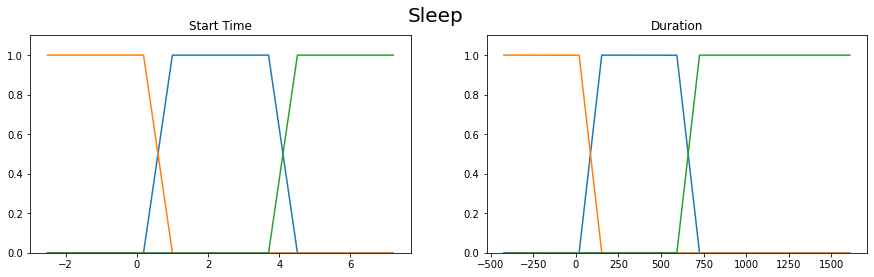

In [57]:
row = normal3.iloc[0]
sb,sc,db,dc = row['Min_Start'], row['Max_Start'], row['Min_Dur'], row['Max_Dur']
plot_fuzzy(sb,sc,db,dc, row['Activity'])